# Laboratory #4_1 : Image Classification using CNN

At the end of this laboratory, you would get familiarized with

*   Creating deep networks using Keras
*   Steps necessary in training a neural network
*   Prediction and performance analysis using neural networks
*   Using pre-trained networks
*   Feature visualizations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

# **Colaboratory environment**
By default, Colab notebooks run on CPU.
You can switch your notebook to run with GPU.

In order to obtain access to the GPU, you need to choose the tab Runtime and then select “Change runtime type” as shown in the following figure:

![Changing runtime](https://miro.medium.com/max/747/1*euE7nGZ0uJQcgvkpgvkoQg.png)

When a pop-up window appears select GPU. Ensure “Hardware accelerator” is set to GPU.

In [ ]:
import numpy as np
import seaborn as sns
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import to_categorical
from keras.backend import clear_session
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, AveragePooling2D, UpSampling2D, Resizing
from keras.optimizers import SGD
from keras.applications import InceptionV3
from keras.applications import ResNet50
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing

In [ ]:
# Auxiliar handcrafted function to plot n images easily
def plot_images(images, size=(10,10), width=0, height=0, limits=[], titles=[], rectangles=[]):
  assert len(images) == len(limits) or limits == [], "Define a number of limits according to the number of images"
  if not width : width  = len(images)
  if not height: height = 1
  fig, axs = plt.subplots(height,width,figsize=size)
  for idx,image in enumerate(images):
    if width != 1 and height != 1:
      axs = axs.flatten()
    ax = axs if width == 1 and height == 1 else axs[idx]
    lim = limits[idx] if limits != [] else (None,None)
    title = titles[idx] if titles != [] else None
    ax.imshow(image, cmap='gray', vmin = lim[0], vmax = lim[1])
    if rectangles and idx < len(rectangles):
      (bestY, bestX), width, heigth, color = rectangles[idx]
      rect = patches.Rectangle((bestY, bestX), width, heigth, linewidth=1, edgecolor=color, facecolor='none')
      ax.add_patch(rect)
    ax.set_title(title)
    ax.set_xticks([]); 
    ax.set_yticks([])
  plt.show()

In [ ]:
random_state = 33

# **Working with a new dataset: CIFAR-10**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. More information about CIFAR-10 can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

In Keras, the CIFAR-10 dataset is also preloaded in the form of four Numpy arrays. x_train and y_train contain the training set, while x_test and y_test contain the test data. The images are encoded as Numpy arrays and their corresponding labels ranging from 0 to 9.

Your task is to:

*   Visualize the images in CIFAR-10 dataset. Create a 10 x 10 plot showing 10 random samples from each class.
*   Convert the labels to one-hot encoded form.
*   Normalize the images.




## Read the data

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

n_labels = len(np.unique(y_train))

print("Train images shape:", x_train.shape)
print("Test images shape:", x_test.shape)
print("Train labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

170498071/170498071 [==============================] - 14s 0us/step
Train images shape: (50000, 32, 32, 3)
Test images shape: (10000, 32, 32, 3)
Train labels shape: (50000,)
Test labels shape: (10000,)


Notice that we have 50k color images (3 channels) of size 32x32 pixels and 10k for the test set of the same size.

## Show the data

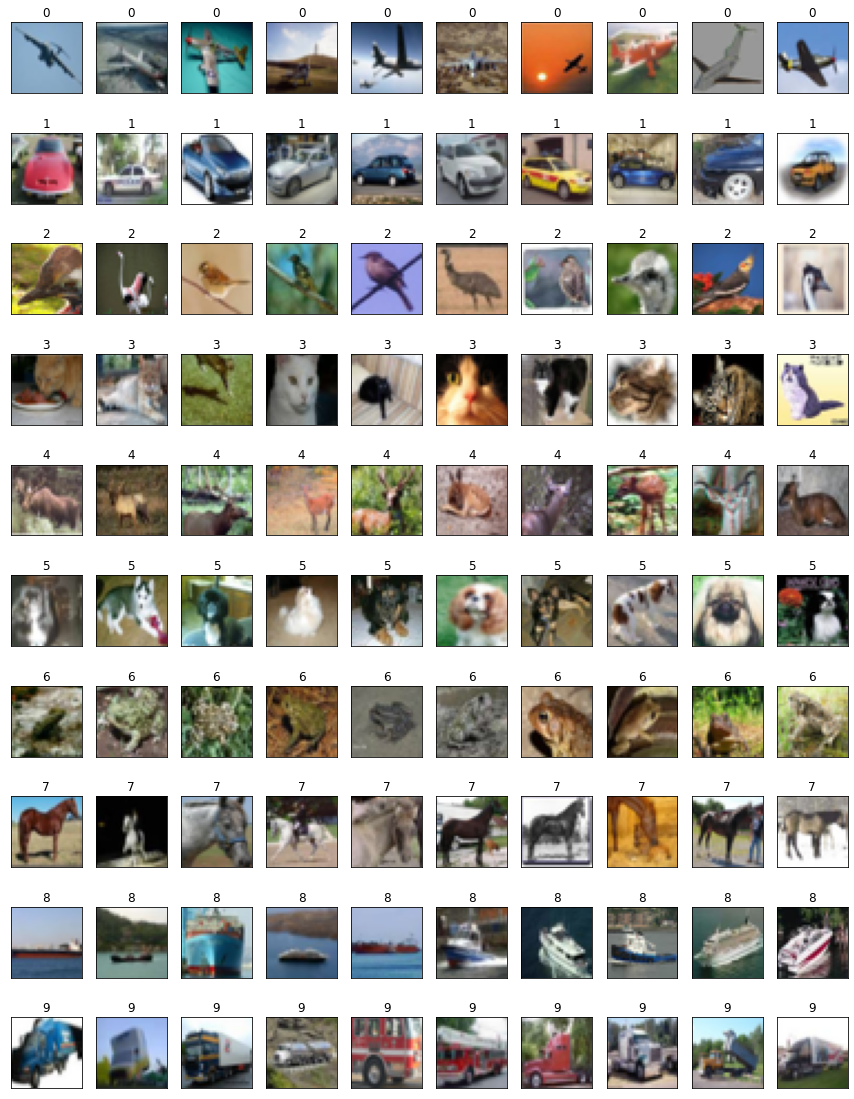

In [ ]:
images = []
labels = []
n_random_images = 10
for label in range(n_labels): # from 0 to 10
  indices = np.where(y_train.squeeze() == label)[0]
  random_indices = np.random.choice(indices, n_random_images)
  for image in x_train[random_indices]:
    images.append(image)
    labels.append(label)

plot_images(images, size=(15,20), height=10, width=10, titles=labels)

In [ ]:
categories = ["Plane","Car","Bird","Cat","Deer","Dog","Frog","Horse","Boat","Truck"]

On the images above we can see which are the categories of the dataset and 10 random examples of each one. We had defined the array *categories* in order to better plot the confussion matrices we will see in the next sections.

## Data normalization

We did this in order to normalize between 0 and 1 the values of all the images.

In [ ]:
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


## Preparing the labels

We prepare the labels to one hot encoding in order to use the next's section networks.

In [ ]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


## Define the following model (same as the one in tutorial)

**For the convolutional front-end, start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. Use the input as (32,32,3). The filter maps can then be flattened to provide features to the classifier. Use a dense layer with 100 units before the classification layer (which is also a dense layer with softmax activation).**

In [ ]:
clear_session()

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 100)               819300    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 821,206
Trainable params: 821,206
Non-trainable params: 0
__________________________________________________

*   **Compile the model using categorical_crossentropy loss, SGD optimizer and use 'accuracy' as the metric.**
*   **Use the above defined model to train CIFAR-10 and train the model for 512 epochs with a batch size of 32.**

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(x_train, y_train, batch_size=32, epochs=512, validation_split=0.1)

Epoch 1/512
1407/1407 [==============================] - 5s 3ms/step - loss: 0.2782 - accuracy: 0.9163 - val_loss: 1.3647 - val_accuracy: 0.6376
Epoch 2/512
1407/1407 [==============================] - 5s 4ms/step - loss: 0.2518 - accuracy: 0.9249 - val_loss: 1.3192 - val_accuracy: 0.6464
Epoch 3/512
1407/1407 [==============================] - 5s 4ms/step - loss: 0.2321 - accuracy: 0.9329 - val_loss: 1.4125 - val_accuracy: 0.6374
Epoch 4/512
1407/1407 [==============================] - 5s 4ms/step - loss: 0.2151 - accuracy: 0.9386 - val_loss: 1.7437 - val_accuracy: 0.5992
Epoch 5/512
1407/1407 [==============================] - 5s 3ms/step - loss: 0.1944 - accuracy: 0.9465 - val_loss: 1.3388 - val_accuracy: 0.6568
Epoch 6/512
1407/1407 [==============================] - 5s 4ms/step - loss: 0.1782 - accuracy: 0.9537 - val_loss: 1.7255 - val_accuracy: 0.5948
Epoch 7/512
1407/1407 [==============================] - 5s 4ms/step - loss: 0.1615 - accuracy: 0.9593 - val_loss: 1.5418 - val_ac

## Results


### Train
On this followint plot we show the cross entropy loss results for the net using the train and validation set. We can also see the accuracy and the validation accuracy in the second subplot. 

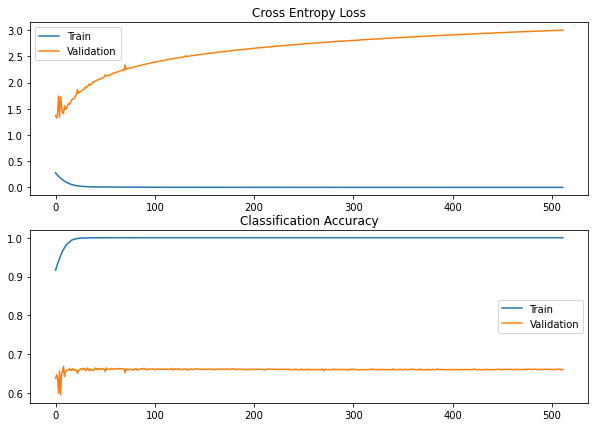

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,7))
ax1.set_title('Cross Entropy Loss')
ax1.plot(history.history['loss'], label='Train')
ax1.plot(history.history['val_loss'], label='Validation')
ax1.legend()

ax2.set_title('Classification Accuracy')
ax2.plot(history.history['accuracy'], label='Train')
ax2.plot(history.history['val_accuracy'], label='Validation')
ax2.legend()
plt.show()

We can see from the image above that this network is making a huge overfit to the data. With only a few epochs, the train's accuracy (loss) reaches 1 (0). The network is overfitting because we can see that, after some fluctuations in the validation values, these ones stagnate or even get worse, such as the cross-entropy loss.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 2.9795 - accuracy: 0.6556
Test loss: 2.9794976711273193
Test accuracy: 0.6556000113487244


### Test
Considering the test set, we can also check that the network is overfitting because the accuracy is only 65% (compared to the 100% of the training set). Now we will take a look at the confusion matrix to see in detail the misclassification that was made.

In [ ]:
y_test_pred = model.predict(x_test)
y_test_pred_label = np.argmax(y_test_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 2ms/step


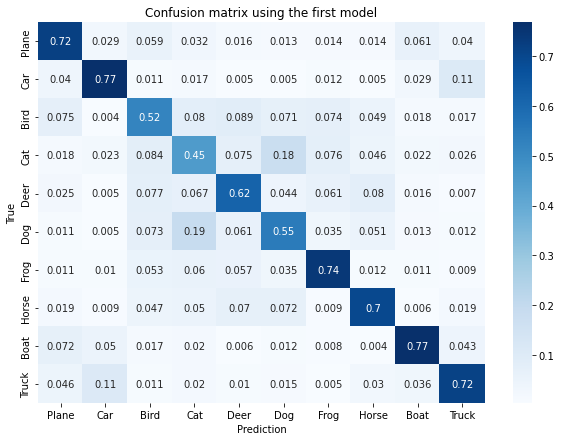

In [ ]:
fig, axs = plt.subplots(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test_label, y_test_pred_label,normalize="true")
sns.heatmap(conf_matrix,annot=True,cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion matrix using the first model")
plt.show()

We can see that there are two distinct groups that have varying degrees of difficulty being identified. Specifically, most of the categories are correctly labeled with around 72% accuracy, while there are 4 classes (bird, cat, deer and dog) that have a bit more problems with the task. Furthermore, it is very interesting to see that the model is having issues with cats and dogs, which are categories that the model frequently misclassifies one for the other. This is probably due to the fact that the images of cats and dogs are taken from similar perspectives and are indeed really similar. However, we can see a clear diagonal in the confusion matrix that leads to the conclusion that the model is not performing as badly as it seems. Even so, the overfitting produced by this network is far from acceptable, as its capacity to generalize is really skewed.

## Defining Deeper Architectures: VGG Models

*   Define a deeper model architecture for CIFAR-10 dataset and train the new model for 512 epochs with a batch size of 32. We will use VGG model as the architecture.

**Stack two convolutional layers with 32 filters, each of 3 x 3. Use a max pooling layer and next flatten the output of the previous layer and add a dense layer with 128 units before the classification layer. For all the layers, use ReLU activation function. Use same padding for the layers to ensure that the height and width of each layer output matches the input**


In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding="same"))
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3), padding="same"))
model2.add(MaxPooling2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dense(10, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                      

*   **Compile the model using categorical_crossentropy loss, SGD optimizer and use 'accuracy' as the metric.**
*   **Use the above defined model to train CIFAR-10 and train the model for 512 epochs with a batch size of 32.**

In [ ]:
%%time
model2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, batch_size=32, epochs=512, validation_split=0.1)

Epoch 1/512
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3399 - accuracy: 0.5209 - val_loss: 1.2740 - val_accuracy: 0.5398
Epoch 2/512
1407/1407 [==============================] - 6s 4ms/step - loss: 1.1658 - accuracy: 0.5903 - val_loss: 1.1646 - val_accuracy: 0.5844
Epoch 3/512
1407/1407 [==============================] - 6s 4ms/step - loss: 1.0495 - accuracy: 0.6321 - val_loss: 1.1141 - val_accuracy: 0.6076
Epoch 4/512
1407/1407 [==============================] - 6s 4ms/step - loss: 0.9519 - accuracy: 0.6700 - val_loss: 1.0602 - val_accuracy: 0.6248
Epoch 5/512
1407/1407 [==============================] - 6s 4ms/step - loss: 0.8720 - accuracy: 0.6960 - val_loss: 1.1420 - val_accuracy: 0.6090
Epoch 6/512
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7921 - accuracy: 0.7254 - val_loss: 1.0610 - val_accuracy: 0.6404
Epoch 7/512
1407/1407 [==============================] - 7s 5ms/step - loss: 0.7203 - accuracy: 0.7525 - val_loss: 1.0581 - val_ac

*   **Compare the performance of both the models by plotting the loss and accuracy curves of both the training steps. Does the deeper model perform better? Comment on the observation.**
 

In [ ]:
def plot_loss_accuracy(history1, history2, name1, name2):
  fig, (axs1,axs2) = plt.subplots(2,2,figsize=(20,10))
  axs1[0].set_title('Loss')
  axs1[0].plot(history1.history['loss'], label=f'{name1} model')
  axs1[0].plot(history2.history['loss'], label=f'{name2} model')
  axs1[0].legend()

  axs1[1].set_title('Validation loss')
  axs1[1].plot(history1.history['val_loss'], label=f'{name1} model')
  axs1[1].plot(history2.history['val_loss'], label=f'{name2} model')
  axs1[1].legend()

  axs2[0].set_title('Accuracy')
  axs2[0].plot(history1.history['accuracy'], label=f'{name1} model')
  axs2[0].plot(history2.history['accuracy'], label=f'{name2} model')
  axs2[0].legend()

  axs2[1].set_title('Validation accuracy')
  axs2[1].plot(history1.history['val_accuracy'], label=f'{name1} model')
  axs2[1].plot(history2.history['val_accuracy'], label=f'{name2} model')
  axs2[1].legend()
  plt.show()

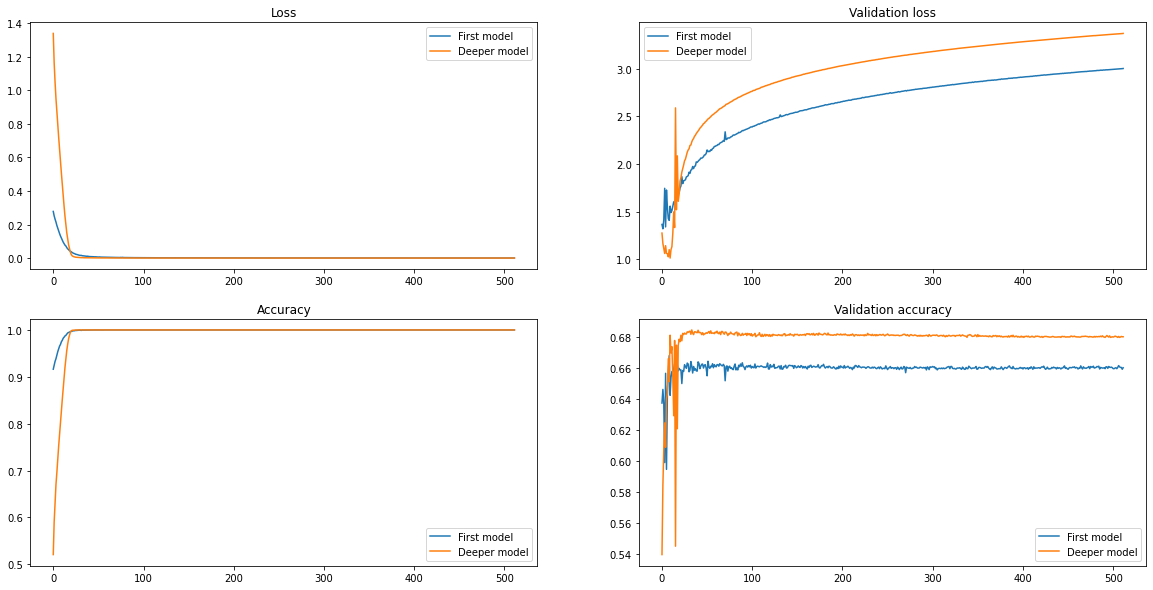

In [ ]:
plot_loss_accuracy(history, history2, "First", "Deeper")

In the previous plots, we can see the comparison between the first and the deeper model. We can see how both of them have similar behaviors. The deeper model, on the other hand, faces greater initial difficulties in achieving 100% accuracy. As we had mentioned in the previous section, this model is also overfitting the data, and the validation shows that by obtaining a flat accuracy that didn't improve while the train accuracy is at 100%. Basically, those models are memorizing the data so much that their ability to generalize is being reduced.

*   **Use predict function to predict the output for the test split**
*   **Plot the confusion matrix for the new model and comment on the class confusions.**


313/313 [==============================] - 1s 2ms/step


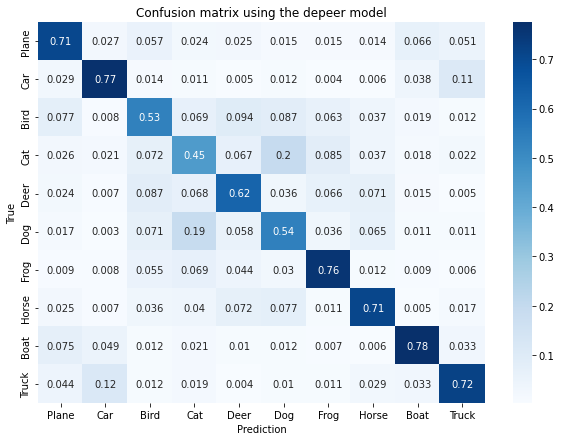

In [ ]:
y_test_pred = model2.predict(x_test)
y_test_pred_label = np.argmax(y_test_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)
fig, axs = plt.subplots(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test_label, y_test_pred_label,normalize="true")
sns.heatmap(conf_matrix,annot=True,cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion matrix using the depeer model")
plt.show()

On this model, we face similar problems that we encountered with the first one. Basically, the bird, cat, deer and dog classes have more difficulty being identified correctly. As we had already mentioned, this result looks quite good in general, but we have to remember that it is a model with a lot of overfitting that will not get better results with other datasets as its ability to generalize is practically inexistent.

*    **Print the test accuracy for the trained model.**

In [ ]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 3.6836 - accuracy: 0.6588
Test loss: 3.683579683303833
Test accuracy: 0.6588000059127808


We can see that the resulting accuracy of the deeper model improves slightly compared with the first model. However, we would like to expect higher accuracy with a non-overfitted model that is able to generalize for new data in a proper way. Let's see how a bigger model can perform with the following VGG architecture.

## Define the complete VGG architecture.

**Stack two convolutional layers with 64 filters, each of 3 x 3 followed by max pooling layer. Stack two more convolutional layers with 128 filters, each of 3 x 3, followed by max pooling, follwed by two more convolutional layers with 256 filters, each of 3 x 3, followed by max pooling. Flatten the output of the previous layer and add a dense layer with 128 units before the classification layer. For all the layers, use ReLU activation function. Use same padding for the layers to ensure that the height and width of each layer output matches the input**

*   Change the size of input to 64 x 64.

In [ ]:
clear_session()

As the statement asks for resizing the input to 64x64, we added an UpSampling2D layer that is able to multiply the images by the indicated factor (2 in our case because 23*2 = 64, which is the desired size).

In [ ]:
model3 = Sequential()
model3.add(UpSampling2D((2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding="same"))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding="same"))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding="same"))
model3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding="same"))
model3.add(MaxPooling2D((2, 2)))
model3.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding="same"))
model3.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(64, 64, 3), padding="same"))
model3.add(MaxPooling2D((2, 2)))
model3.add(Flatten())
model3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dense(10, activation='softmax'))

*   **Compile the model using categorical_crossentropy loss, SGD optimizer and use 'accuracy' as the metric.**
*   **Use the above defined model to train CIFAR-10 and train the model for 100 epochs with a batch size of 32.**
*   **Predict the output for the test split and plot the confusion matrix for the new model and comment on the class confusions.**

In [ ]:
model3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.1)

Epoch 1/100
1407/1407 [==============================] - 40s 27ms/step - loss: 1.7146 - accuracy: 0.3845 - val_loss: 1.7434 - val_accuracy: 0.3836
Epoch 2/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1.1979 - accuracy: 0.5750 - val_loss: 1.8078 - val_accuracy: 0.4156
Epoch 3/100
1407/1407 [==============================] - 36s 26ms/step - loss: 0.9518 - accuracy: 0.6673 - val_loss: 1.1224 - val_accuracy: 0.6208
Epoch 4/100
1407/1407 [==============================] - 39s 28ms/step - loss: 0.7624 - accuracy: 0.7339 - val_loss: 1.1078 - val_accuracy: 0.6366
Epoch 5/100
1407/1407 [==============================] - 38s 27ms/step - loss: 0.6042 - accuracy: 0.7898 - val_loss: 1.0417 - val_accuracy: 0.6690
Epoch 6/100
1407/1407 [==============================] - 37s 26ms/step - loss: 0.4495 - accuracy: 0.8422 - val_loss: 0.8968 - val_accuracy: 0.7286
Epoch 7/100
1407/1407 [==============================] - 36s 26ms/step - loss: 0.3108 - accuracy: 0.8924 - val_loss: 2

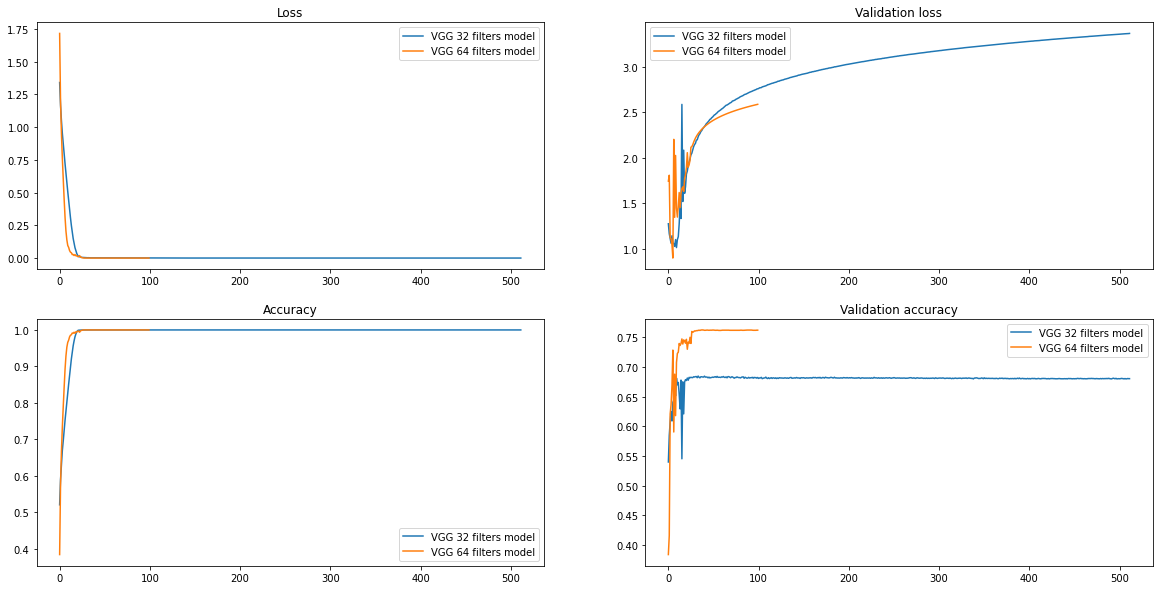

In [ ]:
plot_loss_accuracy(history2, history3, "VGG 32 filters", "VGG 64 filters")

In this block of code, we will comment a little bit on the differences between this last model and the previous one. We can see on the plots the lines of accuracy and loss for the train and validation sets. This last model is the one in orange, while the previous one is the one in blue. As we have been seeing with the previous two models, this one also overfits the data a lot. We can see that because it goes straight to 100% accuracy and 0 loss with the training set, while loss and accuracy increase and stabilize, respectively, with the validation set. Even so, we can see that the accuracy of this new model is quite better than the previous one, achieving around 76%. This is due to the fact that, even if the model is really overfit, it is more capable of generalizing with new data due to its flexibility with the large number of layers used.

313/313 [==============================] - 3s 9ms/step


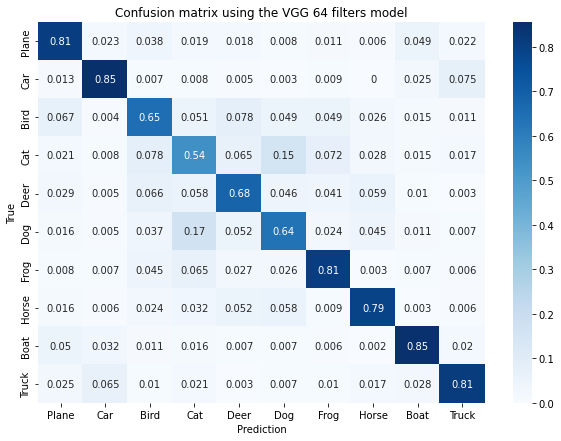

In [ ]:
y_test_pred = model3.predict(x_test)
y_test_pred_label = np.argmax(y_test_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)
fig, axs = plt.subplots(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test_label, y_test_pred_label,normalize="true")
sns.heatmap(conf_matrix,annot=True,cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion matrix using the VGG 64 filters model")
plt.show()

We can take a look at its classification matrix (or confusion matrix) and check that now the model obtains better results with the more complicated categories mentioned with the previous models. However, it still struggles to obtain really good results while the other categories achieve nearly 80% of corrected classified images. In this case, we have to mention that the most "easy" classes to be classified by the model are the car and boat, probably because of the differences with the other categories (even though a truck is quite similar to a car). However, we have to remember, as with the previous ones, that it is an overfitted model that should be used carefully in order to predict and generalize new data in a proper way.

# Understanding deep networks

*   **What is the use of activation functions in network? Why is it needed?**

> The neural network activation function is used to modify the results of a layer in a non-linear manner. Basically it transforms the weighted sum of a neuron so that the output is non-linear. If these activation functions are not used, a neural network will only be like a chain of linear functions, which is indeed a linear function. Just allowing linear classification or regression of the data will lower the capabilities of the neural networks, taking into consideration that there are many problems that are not linear, and they will be far from an optimal solution. \
Adding the activation functions makes the neural networks flexible and capable of adapting to non-linear data in order to obtain good results for predicting future data. There are several of them, such as softmax, relu, tanh, and so on. Each one of these is used for different problems and has different architectures of networks to adapt to different data.

*   **We have used softmax activation function in the exercise. There are other activation functions available too. What is the difference between sigmoid activation and softmax activation?**

> These two functions are indeed very similar. Both take a value x from the range of the real numbers and output a number between 0 and 1 that represents the probability of x belonging to a certain class. Its shape is the following one: \
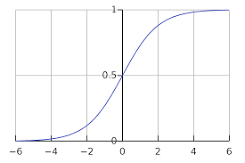 \
The main difference between these two functions is that sigmoid is used for binary classification methods where we only have two classes, while SoftMax applies to multiclass problems. It is important to mention that the SoftMax function is an extension of the Sigmoid function. Information extracted from [here](https://towardsdatascience.com/sigmoid-and-softmax-functions-in-5-minutes-f516c80ea1f9). \
Todo, say something more

*   **What is the difference between categorical crossentropy and binary crossentropy loss?**

> The main difference is that binary crossentropy loss is a special case of categorical crossentropy loss for m=2. In a nutshell, binary crossentropy is used for binary classification (two exclusive classes) while categorical crossentropy is used for multi-class classification (more than two exclusive classes). Information extracted from [here](https://stats.stackexchange.com/questions/260505/should-i-use-a-categorical-cross-entropy-or-binary-cross-entropy-loss-for-binary).

# Transfer Learning

**It is not always necessary to train models from scratch. We can use the knowledge of networks trained on other tasks to learn the task at hand. In this exercise, we will explore the use of pre-trained weights and train on the CIFAR-10 dataset.**

*   **Create a base imagenet pretrained InceptionV3 model.**
    *    Hint: Use tf.keras.applications to create the model
    *    Pay attention to the include_top parameter.


In [ ]:
clear_session()

In [ ]:
iv3 = InceptionV3(include_top=False,weights="imagenet",input_shape=(96,96,3),classes=10)
iv3.trainable=False

*    **Add a global average pooling layer, followed by a fully-connected layer with 1024 neurons and then the classification layer.**

In [ ]:
model4 = Sequential()
model4.add(UpSampling2D((3, 3)))
model4.add(iv3)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
model4.add(Dense(10, activation='softmax'))

Notice that we had added a UpSampling layer of factors 3 and 3 in order to obtain a bigger image (96x96) that the model could accept (at least 75x75).

*   **Train the model by freezing the base model. Train only the newly added layers.**
    *    Hint: Every layer has an attribute called 'trainable'
*   **Compile the model and train the model for a few epochs only.**

In [ ]:
model4.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history4 = model4.fit(x_train, y_train, batch_size=32, epochs=25, validation_split=0.1)

Epoch 1/25
1407/1407 [==============================] - 36s 22ms/step - loss: 1.2207 - accuracy: 0.5909 - val_loss: 1.0478 - val_accuracy: 0.6438
Epoch 2/25
1407/1407 [==============================] - 33s 23ms/step - loss: 0.9578 - accuracy: 0.6768 - val_loss: 1.1559 - val_accuracy: 0.6052
Epoch 3/25
1407/1407 [==============================] - 30s 22ms/step - loss: 0.8637 - accuracy: 0.7069 - val_loss: 0.9691 - val_accuracy: 0.6732
Epoch 4/25
1407/1407 [==============================] - 30s 22ms/step - loss: 0.7891 - accuracy: 0.7335 - val_loss: 1.0543 - val_accuracy: 0.6392
Epoch 5/25
1407/1407 [==============================] - 31s 22ms/step - loss: 0.7212 - accuracy: 0.7565 - val_loss: 0.9811 - val_accuracy: 0.6686
Epoch 6/25
1407/1407 [==============================] - 31s 22ms/step - loss: 0.6561 - accuracy: 0.7807 - val_loss: 0.9561 - val_accuracy: 0.6744
Epoch 7/25
1407/1407 [==============================] - 31s 22ms/step - loss: 0.5955 - accuracy: 0.8034 - val_loss: 0.9763 -

*    **Freeze the bottom layers and unfreeze the base layers.**
*    **Compile and train the classifier with a very low learning rate (0.0001)**

In [ ]:
for i, layer in enumerate(model4.layers):
  if i == 1:
    layer.trainable = True
  else:
    layer.trainable = False

In [ ]:
model4.compile(optimizer=SGD(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history5 = model4.fit(x_train, y_train, batch_size=32, epochs=25, validation_split=0.1)

Epoch 1/25
1407/1407 [==============================] - 93s 62ms/step - loss: 1.9494 - accuracy: 0.3386 - val_loss: 1.6722 - val_accuracy: 0.4726
Epoch 2/25
1407/1407 [==============================] - 86s 61ms/step - loss: 1.4332 - accuracy: 0.4956 - val_loss: 1.3327 - val_accuracy: 0.5552
Epoch 3/25
1407/1407 [==============================] - 90s 64ms/step - loss: 1.2249 - accuracy: 0.5673 - val_loss: 1.1857 - val_accuracy: 0.6092
Epoch 4/25
1407/1407 [==============================] - 86s 61ms/step - loss: 1.0987 - accuracy: 0.6144 - val_loss: 1.0553 - val_accuracy: 0.6444
Epoch 5/25
1407/1407 [==============================] - 87s 62ms/step - loss: 1.0088 - accuracy: 0.6462 - val_loss: 0.9740 - val_accuracy: 0.6724
Epoch 6/25
1407/1407 [==============================] - 88s 62ms/step - loss: 0.9410 - accuracy: 0.6704 - val_loss: 0.9747 - val_accuracy: 0.6842
Epoch 7/25
1407/1407 [==============================] - 85s 60ms/step - loss: 0.8922 - accuracy: 0.6882 - val_loss: 0.9021 -

*    **Compare the performance of the VGG model and the Inception-V3 model.**

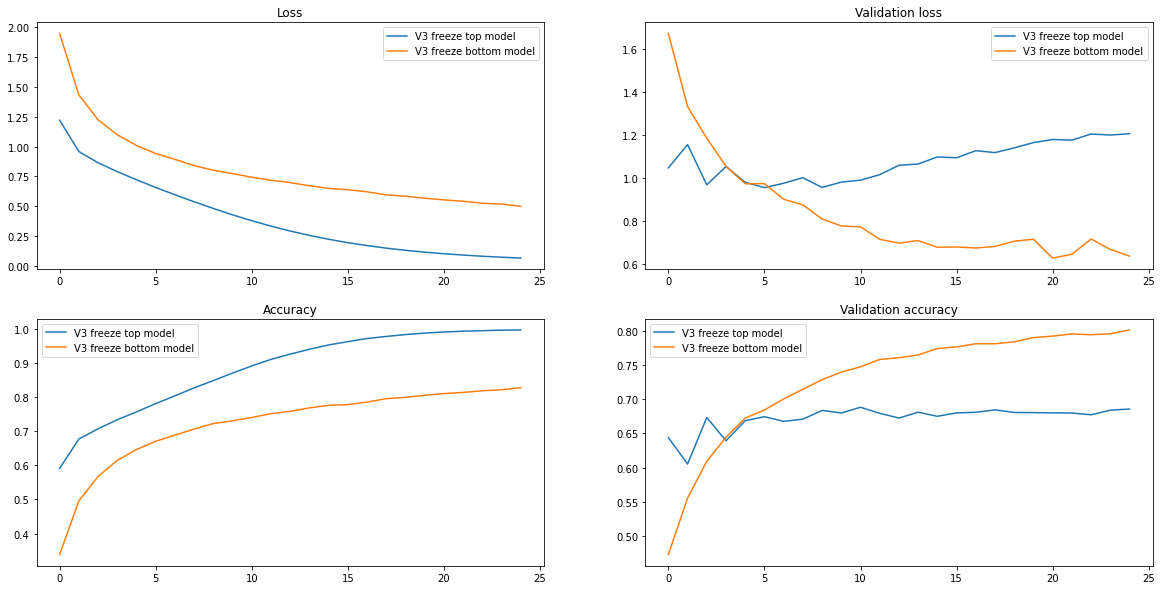

In [ ]:
plot_loss_accuracy(history4, history5, "V3 freeze top", "V3 freeze bottom")

We go through three steps to train the model that uses the IV3 pre-trained model:
1. We create the model.
2. We freeze the base layer and train the bottom layers.
3. We freeze the bottom layers, and we train the base layer.


With this process, we are able to create a model with a great level of accuracy that is not overfitting and can predict with an accuracy of 0.80. If we analyze the last 2 parts of the model training, we can see that in the first part, the model is overfitting and gets a validation accuracy of 0.75. We can see that the validation accuracy does not increase over time, while the train accuracy does, reaching a 100%. Hence, we need to do the final step, which is training the base layer, in order to get nicer results. If we apply the third step, we get a model that doesn't overfit and is correct in 80% of the cases for this specific test set. In the next section, we will compare this final version to the VGG model. 

313/313 [==============================] - 6s 17ms/step


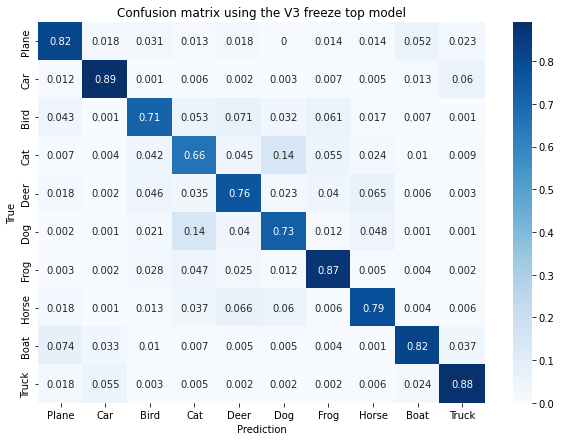

In [ ]:
y_test_pred = model4.predict(x_test)
y_test_pred_label = np.argmax(y_test_pred, axis=1)
y_test_label = np.argmax(y_test, axis=1)
fig, axs = plt.subplots(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test_label, y_test_pred_label,normalize="true")
sns.heatmap(conf_matrix,annot=True,cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion matrix using the V3 freeze top model")
plt.show()




In order to compare with VGG, we will use the best model of VGG, i.e., VGG with 64 filters. If we look at the accuracy plots of the VGG model, we can see that in train data we obtain an accuracy of 1.00 and a validation accuracy of about 0.75. As we have mentioned before, looking at these numbers and the accuracy plots, we know that the model is overfitting.

Moreover, using the plots of the IV3 model, we can see that we are obtaining an accuracy near 0.80 in the train data. If we see the validation accuracy, we can appreciate that the validation accuracy is also near 0.80. Actually, if we study the curves of the accuracy and the validation accuracy, we can notice that they have the same trend. So, we can say that in the case of the IV3 model, we don't have the overfitting problem. It's more, we have more accuracy than VGG with overfitting.

Using the confusion matrix of both models, we can see that the IV3 model is better. We can see similar confusion matrices, but IV3 has improvements. We can notice that the prediction of all the classes has improved. Even though the improvement in accuracy for each class is minor, it is noticeable. The reason for this is that the VGG model is obtaining the same results because of the overfitting. Furthermore, we can now predict with greater certainty the problematic classes (Bird, Cat, Deer, and Dog). However, the model still has problems differentiating between the dog and cat categories.




*    **When do we train models from scratch? What are the potential issues in training models from scratch?**

> Because there may not be a pre-trained model that can solve our problem, we train models from scratch. Moreover, there can't be general models that solve all kinds of classification problems. We need to give them new data and try to make the model learn the patterns behind the data. And in order to do that, we need to train models from scratch.\
However, training models from scratch takes a huge amount of time and storage. First of all, in order to create good quality models, we need to train our models with enough epochs to assure that the model has learned the data patterns. Obviously, the higher the number of epochs, the higher the amount of time spent training the model. Moreover, while learning, the models need huge quantities of storage (RAM). Apart from the time and space issues, we may face problems such as overfitting. Due to this, we may think that we have a great model, but this may not be the case because it may not behave well in the testing dataset.

*    **Why do we use pre-trained weights?**

> For image recognition tasks, using a pre-trained model has many advantages. The first reason we use pre-trained weights is that it saves time and effort by requiring less training and model architecture development. Instead, the model's definition is already provided. The accuracy of the model is another reason. Pre-trained models are considerably more accurate than convolutional neural networks created from scratch. Therefore, starting with a pre-trained model while doing image recognition tasks would make sense because it is almost always the smartest move to make.

*    **What is the difference between using random initialization and using weights from a pre-trained model?**

> Models that use pre-trained weights are better at detecting features like edges, patterns, etc. These models understand certain feature representations, which can be reused. Due to this, models that use pre-trained weights have quicker convergence and are used in tasks like object detection, segmentation, etc. On the other hand, models using random initialization can obtain the same results; however, the time spent achieving the results is quite high compared to pre-trained models. And in some cases, the model using random initialization may not achieve the same level of accuracy.

# Extracting features from Deep Networks

It is quite possible to extract features (similar to SIFT or ORB) from different layers of deep network.

*   Load ResNet50 model with imagenet weights and check the summary of the model
*   Create a model to extract features from the 'avg_pool' layer.
*   Extract features from the layer for all the train images.
*   Use the extracted features to train a SVM classifier.
    *    Use GridSearchCV and SVC to perform the classification

In [ ]:
resnet = ResNet50(include_top=False,weights="imagenet",input_shape=(32,32,3),classes=10, pooling='avg')
resnet.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                          

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255


train_features_dataset = resnet.predict(x_train)
test_features_dataset = resnet.predict(x_test)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

n_labels = len(np.unique(y_train))

print("Train feature images shape:", train_features_dataset.shape)
print("Test feature images shape:", test_features_dataset.shape)
print("Train labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

313/313 [==============================] - 43s 137ms/step
Train feature images shape: (50000, 2048)
Test feature images shape: (10000, 2048)
Train labels shape: (50000,)
Test labels shape: (10000,)


In [ ]:
%%time
s = SVC().fit(train_features_dataset, y_train)

CPU times: user 1h 16min 47s, sys: 6.97 s, total: 1h 16min 54s
Wall time: 1h 17min 3s


*    Evaluate the trained SVM model using the test set
*    Calculate the accuracy score and confusion matrix

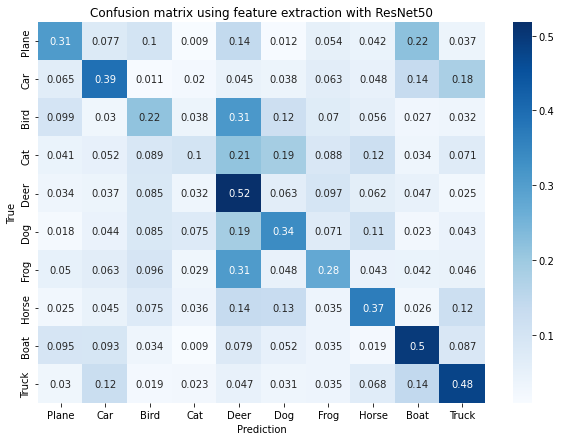

CPU times: user 15min 6s, sys: 979 ms, total: 15min 7s
Wall time: 15min 2s


In [ ]:
%%time
y_test_pred = s.predict(test_features_dataset)
conf_matrix = confusion_matrix(y_test, y_test_pred,normalize="true")
fig, axs = plt.subplots(figsize=(10, 7))
sns.heatmap(conf_matrix,annot=True,cmap='Blues',xticklabels=categories,yticklabels=categories)
plt.ylabel("True")
plt.xlabel("Prediction")
plt.title("Confusion matrix using feature extraction with ResNet50")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy with the test set of",accuracy_score(y_test, y_test_pred)*100,"%")

Accuracy with the test set of 34.93 %


In this exercise, we use the ResNet50 model to extract the important features of the data. We use ResNet50 with the average pooling layer as the last layer. With this, the results of the model are the output of the average pooling layer.


Once we've done the feature extraction, we can use the new data for training the SVC model. In order to do that, we needed to do a grid search over a range of parameters in order to find the best model possible. However, if we look at the execution time of one SVC model with our data, we can see it takes 1 hour and 20 minutes. After trying to get the best model of SVC, we concluded that it was not feasible because it would take days. So, in this case, we decided to train just one SVC with the new data and the default parameters still knowing that are maybe not the best ones to be used.


By looking at the confusion matrix, we can see that the model behaves poorly and the results are extremely confusing. The prediction accuracy of all the classes is under 0.50, which is incredibly low. We can appreciate that the lowest class is cat, and most of the classes around the deer class are confused by the model. The classes of bird, cat, dog, and frog are frequently confused with the class of deer. By looking at this confusion matrix, we can see that the accuracy is also very poor. With the default parameters of the SVC and the transformed data, we get an accuracy of only 34.93%.

We could have gotten much better results finding the "correct" parameters of the SVC, which is known for being extremely parameter dependent, but time constraints prevented us from evaluating this fact.

# Feature Visualizations

In order to visualize the features of a higher dimension data, t-SNE is used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.

You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

*    Use TSNE to visualize the features extracted in the previous exercise.
    *    Hint: TSNE function is available in the *sklearn.manifold* package.

In [ ]:
from sklearn.manifold import TSNE

new_data = TSNE(n_components=3,random_state=random_state).fit_transform(test_features_dataset)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


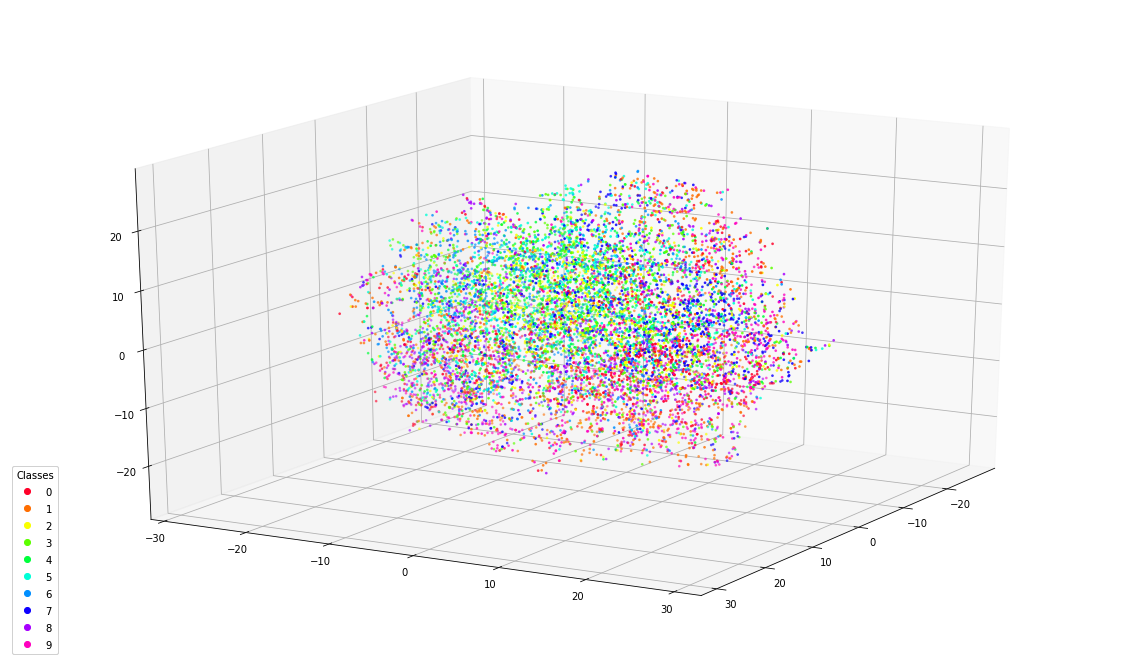

In [ ]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(xs=new_data[:,0], ys=new_data[:, 1], zs=new_data[:, 2], c=y_test, s=3, label=np.array(categories)[y_test], cmap='gist_rainbow')

# Code for producing the legend copied from the documentation
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_with_legend.html
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

ax.view_init(elev=20.,azim=30)
plt.show()

*    **Why is feature visualization helpful?**

> Typically, we use feature visualization techniques to better understand the distribution of data in three or two dimensions. This lets us understand how the classes are distributed among the space. In our case, if we try to plot the new data after applying t-SNE, we can see that all the points are quite concentrated in the center of the graph. We can see that there is no clear distinction between the classes, everything seems to be a big mix. We can appreciate that in some parts of the graph there are more points of one of the classes, such as the "group" of green points; however, that is not enough to decide how we could divide the classes over the three-dimensional space.\
Although the visualization of the data is not really useful, it is known that t-SNE is a highly robust and remarkable reduction technique that works really well for visualization purposes in a great deal of problems.


---

## **End of P4_1: Image Classification using CNN**
Deadline for P4_1 submission in CampusVirtual is: **Monday, the 24th of November, 2022**